In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.special import spherical_jn as j_l
from scipy.special import spherical_in as i_l
from spherical_bessel_zeros import Jn_zeros
from scipy.integrate import quadrature

In [2]:
lmax = 10
nmax = 10
a = 3.5  # Radius of the sphere

In [3]:
z_ln = Jn_zeros(lmax, nmax)  # Spherical Bessel zeros
z_nl = z_ln.T

In [4]:
def R_nl(n, l, r):
    return j_l(l, z_nl[n, l]*r/a)

def N_nl(n, l):
    # Normalization factor for LE basis functions
    def function_to_integrate_to_get_normalization_factor(x):
        return j_l(l, x)**2 * x**2
    integral, _ = sp.integrate.quadrature(function_to_integrate_to_get_normalization_factor, 0.0, z_nl[n, l])
    return (1.0/z_nl[n, l]**3 * integral)**(-0.5)

def get_LE_function_python(n, l, r):
    R = np.zeros_like(r)
    for i in range(r.shape[0]):
        R[i] = R_nl(n, l, r[i])
    return N_nl(n, l)*R*a**(-1.5)

In [5]:
# Python normalization check:

def what(x):
    return get_LE_function_python(1, 1, x)**2 * x**2

print(sp.integrate.quadrature(what, 0.0, a))

(0.9999999999999998, 8.329107625826282e-09)


In [6]:
# Now the mollified version

def evaluate_LE_function_mollified_python(n, l, r):
    sigma = 0.2
    c = 1.0/(2.0*sigma**2)
    def function_to_integrate(x):
        return x**2 * get_LE_function_python(n, l, x) * np.exp(-c*x**2) * i_l(l, 2.0*c*x*r)
    integral, error = sp.integrate.quadrature(function_to_integrate, 0.0, 3.5)
    return 4.0*np.pi*np.exp(-c*r**2)*integral*(1.0/(np.sqrt(2*np.pi)*sigma))**3

def get_LE_function_mollified_python(n, l, r):
    R = np.zeros_like(r)
    for i in range(r.shape[0]):
        R[i] = evaluate_LE_function_mollified_python(n, l, r[i])
    return R

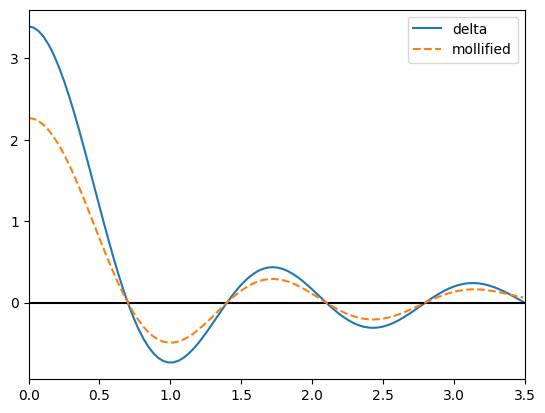

In [7]:
x = np.linspace(0.0, 3.49, 100)
y_delta = get_LE_function_python(n=4, l=0, r=x)
plt.plot(x, y_delta, label="delta")
plt.plot([0.0, a], [0.0, 0.0], "black")
y_mollified = get_LE_function_mollified_python(4, 0, x)
plt.plot(x, y_mollified, "--", label="mollified")
plt.xlim(0.0, a)
plt.legend()
plt.show()

In [8]:
# Radially dependent Gaussian smoothing:

def sigma(r):
    return 0.15 + 0.3*r/a

def evaluate_LE_function_mollified_adaptive(n, l, r):
    c = 1.0/(2.0*sigma(r)**2)
    def function_to_integrate(x):
        return x**2 * get_LE_function_python(n, l, x) * np.exp(-c*x**2) * i_l(l, 2.0*c*x*r)
    integral, error = sp.integrate.quadrature(function_to_integrate, 0.0, 3.5)
    return 4.0*np.pi*np.exp(-c*r**2)*integral*(1.0/(np.sqrt(2*np.pi)*sigma(r)))**3

def get_LE_function_mollified_adaptive(n, l, r):
    R = np.zeros_like(r)
    for i in range(r.shape[0]):
        R[i] = evaluate_LE_function_mollified_adaptive(n, l, r[i])
    return R

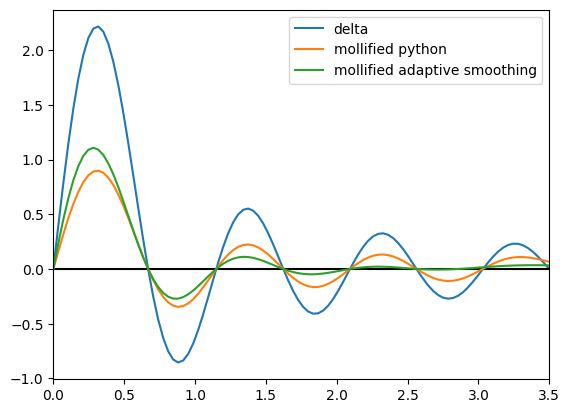

In [9]:
x = np.linspace(0.0, 3.49, 100)
y_delta = get_LE_function_python(n=6, l=1, r=x)
plt.plot(x, y_delta, label="delta")
plt.plot([0.0, a], [0.0, 0.0], "black")
y_mollified = get_LE_function_mollified_python(6, 1, x)
plt.plot(x, y_mollified, label="mollified python")
y_mollified_adaptive = get_LE_function_mollified_adaptive(6, 1, x)
plt.plot(x, y_mollified_adaptive, label="mollified adaptive smoothing")
plt.xlim(0.0, a)
plt.legend()
plt.show()

In [10]:
# Feed LE (delta) radial spline points to Rust calculator:

n_spline_points = 101
spline_x = np.linspace(0.0, a, n_spline_points)  # x values

spline_f = []
for l in range(lmax+1):
    for n in range(nmax):
        spline_f_single = get_LE_function_python(n, l, spline_x)
        spline_f.append(spline_f_single)
spline_f = np.array(spline_f).T
spline_f = spline_f.reshape(n_spline_points, lmax+1, nmax)  # f(x) values

In [11]:
def get_LE_function_derivative(n, l, r):
    delta = 1e-6
    all_derivatives_except_at_zero = (get_LE_function_python(n, l, r[1:]+delta) - get_LE_function_python(n, l, r[1:]-delta)) / (2.0*delta)
    derivative_at_zero = (get_LE_function_python(n, l, np.array([delta/10.0])) - get_LE_function_python(n, l, np.array([0.0]))) / (delta/10.0)
    return np.concatenate([derivative_at_zero, all_derivatives_except_at_zero])

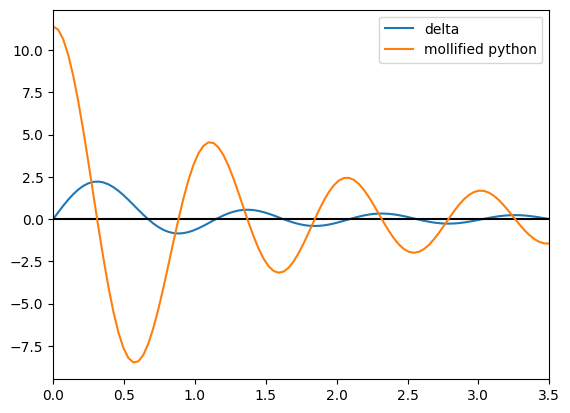

In [12]:
x = np.linspace(0.0, a, 100)
f = get_LE_function_python(n=6, l=1, r=x)
plt.plot(x, f, label="delta")
plt.plot([0.0, a], [0.0, 0.0], "black")
df = get_LE_function_derivative(6, 1, x)
plt.plot(x, df, label="mollified python")
plt.xlim(0.0, a)
plt.legend()
plt.show()

In [13]:
spline_df = []
for l in range(lmax+1):
    for n in range(nmax):
        spline_df_single = get_LE_function_derivative(n, l, spline_x)
        spline_df.append(spline_df_single)
spline_df = np.array(spline_df).T
spline_df = spline_df.reshape(n_spline_points, lmax+1, nmax)  # df/dx values

In [14]:
with open("splines.txt", "w") as file:
    np.savetxt(file, spline_x.flatten(), newline=" ")
    file.write("\n")

with open("splines.txt", "a") as file:
    np.savetxt(file, spline_f.flatten(), newline=" ")
    file.write("\n")
    np.savetxt(file, spline_df.flatten(), newline=" ")
    file.write("\n")

In [15]:
from rascaline import SphericalExpansion

hypers_spherical_expansion = {
        "cutoff": a,
        "max_radial": nmax,
        "max_angular": lmax,
        "center_atom_weight": 0.0,
        "radial_basis": {"Tabulated": {"file": "splines.txt"}},
        # "radial_basis": {"Gto": {}},
        "atomic_gaussian_width": 1.0,
        "cutoff_function": {"Step": {}},
    }

calculator = SphericalExpansion(**hypers_spherical_expansion)

In [16]:
import ase

def get_dummy_structures(r_array):
    dummy_structures = []
    for r in r_array:
        dummy_structures.append(
            ase.Atoms('CH', positions=[(0, 0, 0), (0, 0, r)])
        )
    return dummy_structures 

In [36]:
# Create a fake list of dummy structures to test the radial functions generated from rascaline.

r = np.linspace(0.1, 3.4, 100)
structures = get_dummy_structures(r)
print(len(structures))

100


In [37]:
spherical_expansion_coefficients = calculator.compute(structures)

In [38]:
block_C_0 = spherical_expansion_coefficients.block(species_center = 6, spherical_harmonics_l = 0, species_neighbor = 1)
print(block_C_0.values.shape)

(100, 1, 10)


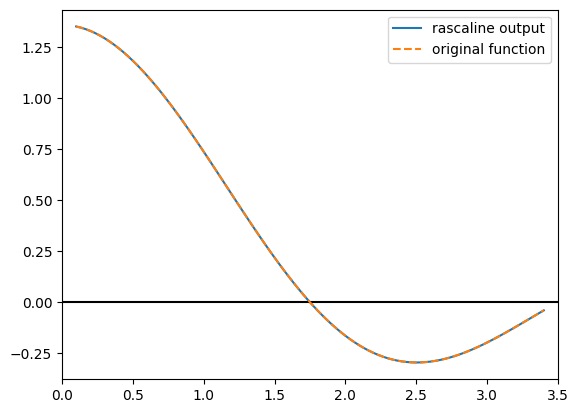

3.5449076949352767
3.5449077018110318


In [61]:
block_C_0_0 = block_C_0.values[:, :, 1].flatten()
spherical_harmonics_0 = 1.0/np.sqrt(4.0*np.pi)

plt.plot(r, block_C_0_0*spherical_harmonics_0, label="rascaline output")  # rascaline BUG?
plt.plot([0.0, a], [0.0, 0.0], "black")
plt.plot(r, get_LE_function_python(n=1, l=0, r=r), "--", label="original function")
plt.xlim(0.0, a)
plt.legend()
plt.show()